<a href="https://colab.research.google.com/github/K4cp3rski/ML_FUW/blob/master/Cybinski_01_zadanie_domowe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 ## "Should I stay, or should I go"
 
Wyobraź sobie, że dołączasz do grupy osób, które mają pomysł na "startup" - aplikację mobilną która wskazuje czy wybrany lot odleci o czasiem czy spóźni się o więcej niż 60'. Aplikacja będzie bardzo użyteczne - jeśli lot ma się opóźnić nie warto wyjeżdzać na lotnisko za wcześnie.

---
Zadanie: skonstruować model uczenia maszytnowego, który przyjume dane o locie, i zwraca informację: 

**Czy lot opóżni się o więcej niż 60'?**  - TAK/NIE
  
1) Proszę użyć nasdępujących modeli:
    * regresja logistyczna
    * naiwny klasyfikator Bayesa
    * drzewa decyzyjne
    * maszyna wektorów nośnych

2) Proszę wskazać kolumnę silnie skorelowaną z etykietą (odpowiedzią na pytanie zadane modelowi).

3) Proszę sprawdzić metryki modeli na zbiorze uczącym i testowym i wskazać model który jest najlepszy.

4) Proszę odpowiedzieć na pytanie: 

**Model stwierdził, że lot opóźni się o więcej niż 60' - użytkownik modelu wyszedł później na lotnisko. 
  Jakie jest prawdopodobieństwo, że w tej sytuacji lot jednak był o czasie (i użytkownik pewnie się na niego spóźnił)?**
  
5) Proszę wyjaśnić dlaczego modele działają tak dobrze.  

---  

**Opis danych:** "The U.S. Department of Transportation's (DOT) Bureau of Transportation Statistics tracks the on-time performance of domestic flights operated by large air carriers. Summary information on the number of on-time, delayed, canceled, and diverted flights is published in DOT's monthly Air Travel Consumer Report and in this dataset of 2015 flight delays and cancellations."

**Lokalizacja danych:** Dane znajdują się na dysku Google tutaj: [flights.csv](https://drive.google.com/file/d/1ryE8mPQlommi88PaeiRSGQJOn4OYte64/view?usp=sharing). Najwygodniejszy sposób dostępu to czytadnie danych bezpośrednio z dysku Google. W tym celu należy utworzyć skrót do pliku na własnym dysku. Po kliknięciu w link należy utworzyć skrót do pliku na własnym dysku Google:

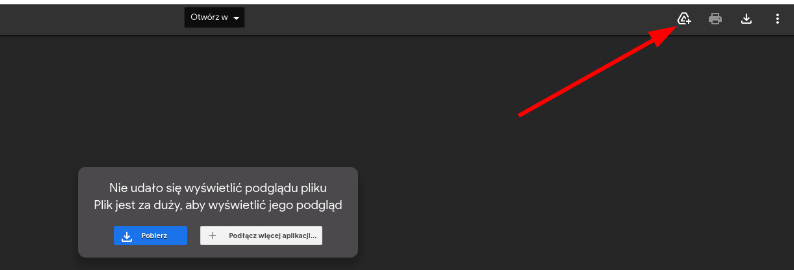



Następnie należy podłączyć dysk Google do środowiska Colab:

In [372]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Ścieżkę do pliku można znaleźć w menu plików z lewej strony:

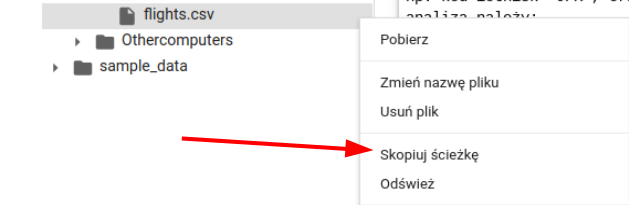


**Wstępna obróbka danych**: dane zawierają kolumny numeryczne, oraz z napisami, np. kod lotnisk "JFK", oraz wiersze gdzie niektóre kolumny są puste. Przed analizą należy:

* usunąć kolumny dla których zwykle nie ma żadnej informacji
* stworzyć kolumnę etykiet zawierającą wartości **0** lub **1** zależnie od tego czy opóźnenie było większe niż 60'
* zamienić napisy na wartości liczbowe korzystając z metody ```Pandas.factorize(...)```:
    
    ```
    df[column] =  pd.factorize(df[column])[0]
    ```
    
* niektóre wiersze mogą nadal zawierać nieokreślone wartości - ```NaN``` - należy je usunąć  
* danych jest bardzo dużo - by przyspieszyć obliczenia do treningu proszę użyć odpowiednio małej części
---
---

# <center>Rozwiązanie</center>


---
##Preprocessing danych

In [390]:
import pandas as pd
import numpy as np
import seaborn as sns

import sklearn
print('Zainstalowana wersja scikit-learn: {}.'.format(sklearn.__version__))

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10) # aby wykresy w Colabie były większe

import numpy as np
from scipy import diag, interp
from itertools import cycle

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn import metrics

# Tutaj trzeba wpisać ścieżekę do pliku w swoim google drive
raw_data = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/ML_2021Z/flights.csv')

Zainstalowana wersja scikit-learn: 1.0.1.


In [391]:
data = raw_data.copy().sample(n=int(raw_data.shape[0]*0.05),random_state=42)
credit_df = data

In [392]:
# BSO bierzemy do pracy 5% danych, dla oszczędności pamięci

data = data.dropna(axis='columns', how='all', thresh=int(0.9*data.shape[0]))

headers = data.columns


data.insert(loc=0, column='DELAYED', value=data['DEPARTURE_DELAY'][data['DEPARTURE_DELAY'] > 60])
data['DELAYED'][data['DELAYED'] > 1] = 1
data['DELAYED'] = data['DELAYED'].fillna(0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:1021: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

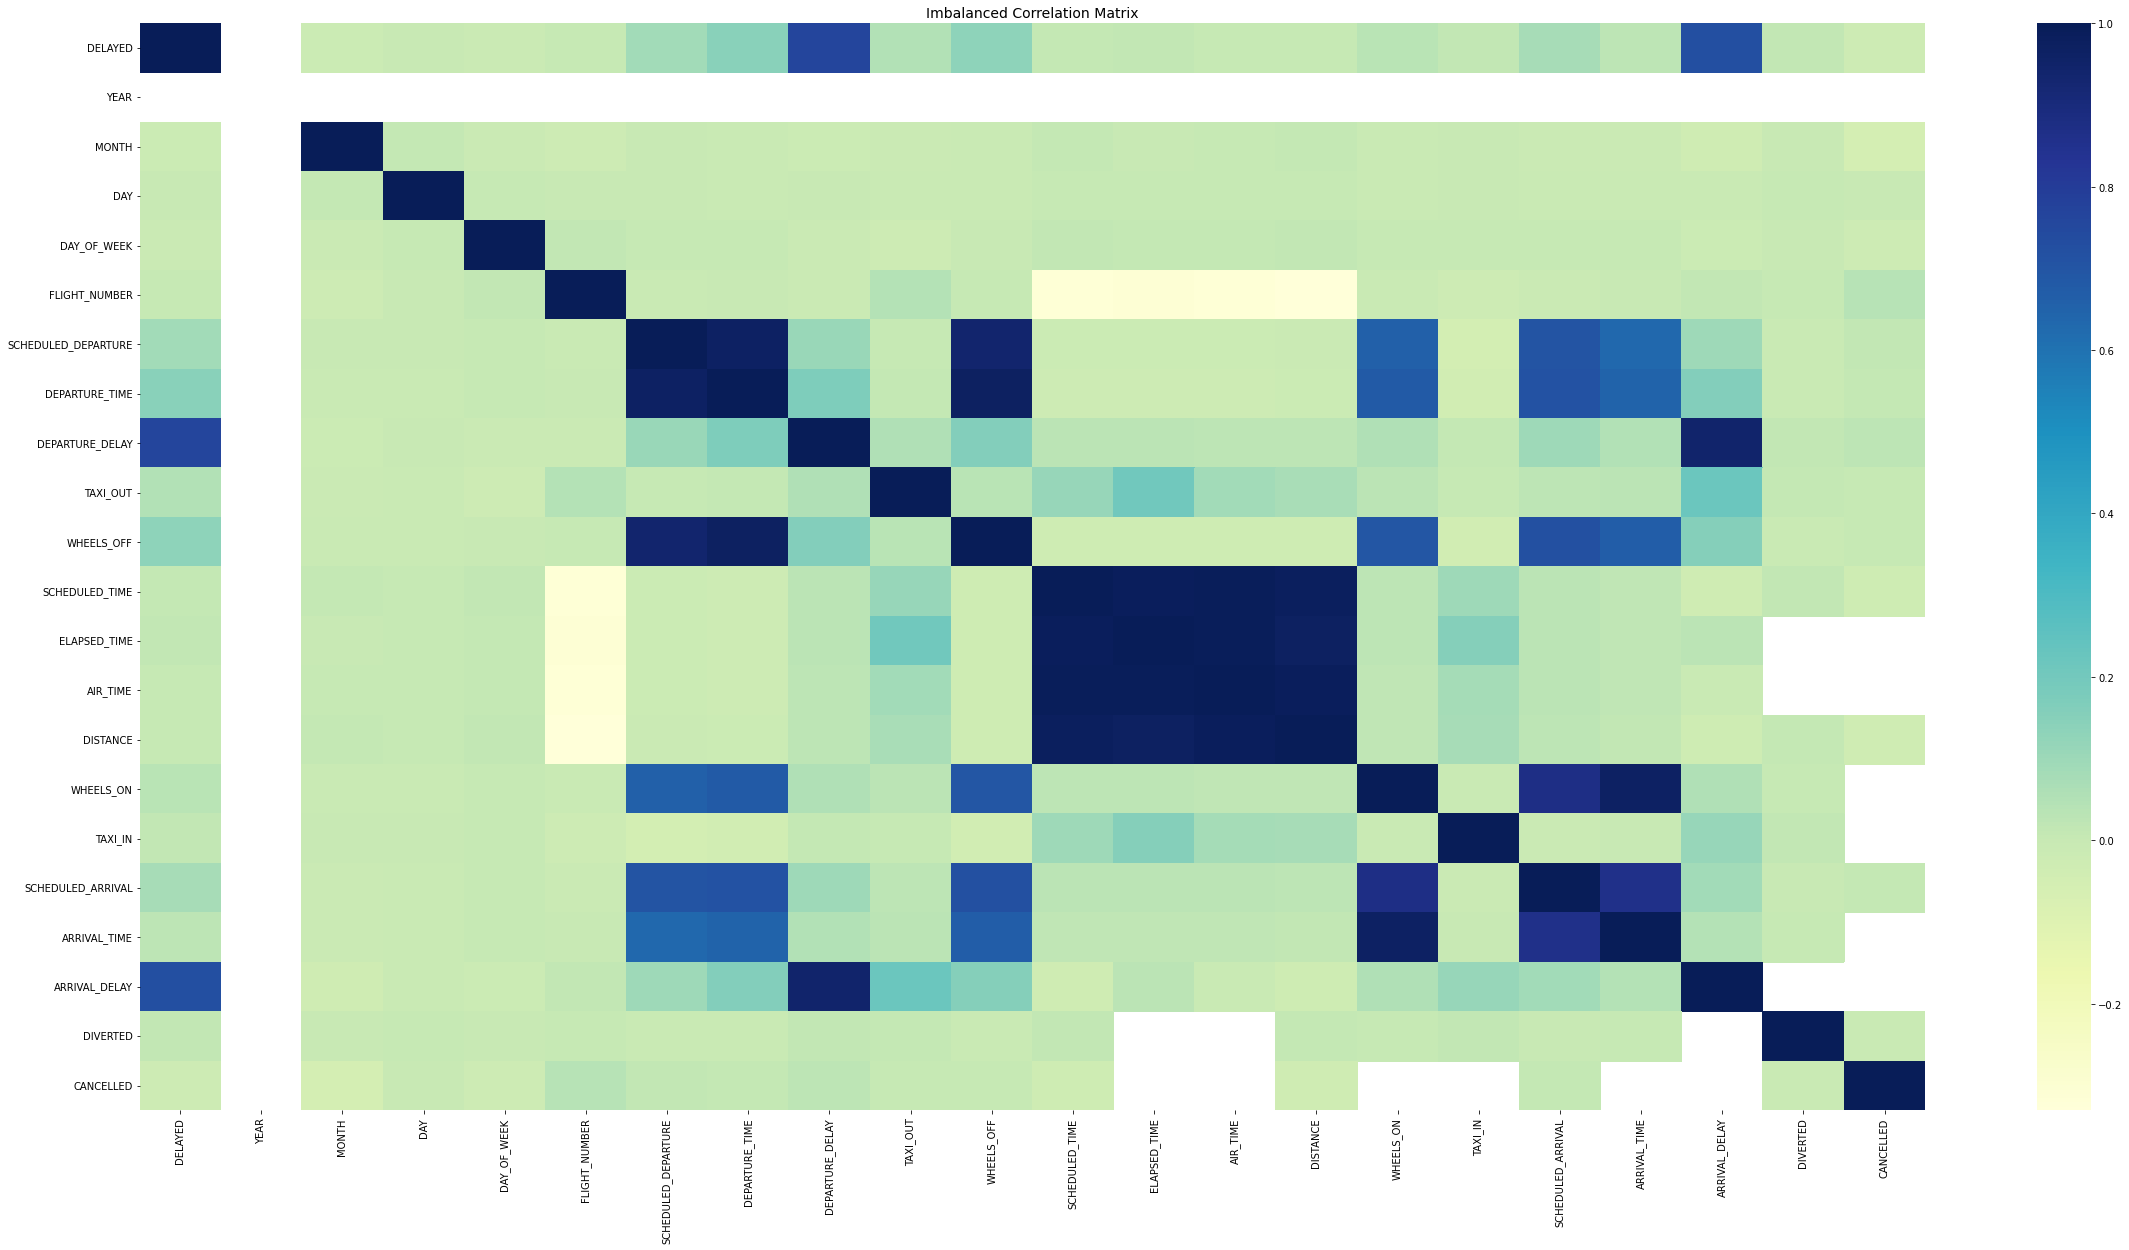

In [393]:
fig, ax = plt.subplots(figsize=(40,20))         
# Imbalanced DataFrame Correlation
corr = data.corr()
sns.heatmap(corr, cmap='YlGnBu', annot_kws={'size':30}, ax=ax)
ax.set_title("Imbalanced Correlation Matrix", fontsize=14)
plt.show()

**Wniosek** Kolumny silnie skorelowane z etykietami to 'ARRIVAL_DELAY' i 'DEPARTURE_DELAY'

In [394]:
# Potem się te wartośći doda w postaci faktoryzowanej
names = ['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT']
alpha = data.loc[:, names]
data = data.drop(columns=alpha)
print("Wartości NaN: {}".format(alpha.isnull().sum().sum()))
alpha = alpha.dropna(axis='rows', how='all')
print("Wartości NaN: {}".format(alpha.isnull().sum().sum()))
# print(alpha)

# Tu tworzymy słownik do późniejszego 
labels = {}
for i, name in enumerate(names):
  alpha[name], labels[name] = pd.factorize(alpha[name])
  # print(pd.factorize(data[name]))

# print(alpha)
print("Wartości NaN: {}".format(data.isnull().sum().sum()))
data = data.dropna(axis='rows', how='all', thresh=int(data.shape[1]))
print("Wartości NaN: {}".format(data.isnull().sum().sum()))
# data

Wartości NaN: 0
Wartości NaN: 0
Wartości NaN: 47060
Wartości NaN: 0


Usuwamy kolumny z danymi niedostępnymi dla zwykłego śmiertelnika (pasażera), żeby model trenować tylko na danych do których finalnie będzie mieć dostep i kolumn silnie skorelowanych (jednej z pary (distance, scheduled_time))

In [395]:
to_drop = ['TAIL_NUMBER', 'DEPARTURE_TIME', 'TAXI_OUT',
       'WHEELS_OFF', 'ELAPSED_TIME', 'AIR_TIME', 'WHEELS_ON', 'TAXI_IN', 'ARRIVAL_TIME',
       'ARRIVAL_DELAY', 'DIVERTED','DEPARTURE_DELAY', 'DISTANCE', 'CANCELLED', 'YEAR']
data = data.drop(columns=to_drop)

print("Wartości NaN: {}".format(data.isnull().sum().sum()))
data

Wartości NaN: 0


,DELAYED,MONTH,DAY,DAY_OF_WEEK,FLIGHT_NUMBER,SCHEDULED_DEPARTURE,DEPARTURE_DELAY,SCHEDULED_TIME,SCHEDULED_ARRIVAL
1508570,0.0,4,7,2,4900,1340,-5.0,56.0,1436
363270,0.0,1,24,6,611,1910,-12.0,155.0,2145
3003945,0.0,7,8,3,1483,630,-4.0,110.0,820
2291425,1.0,5,26,2,193,810,153.0,100.0,950
2973084,0.0,7,6,1,253,1000,8.0,498.0,1318
...,...,...,...,...,...,...,...,...,...
4810438,0.0,10,27,2,1485,1955,1.0,85.0,2120
4946857,0.0,11,5,4,1218,1535,-10.0,135.0,1750
311633,0.0,1,21,3,299,1230,-5.0,148.0,1458
520930,0.0,2,4,3,5364,1156,14.0,49.0,1245


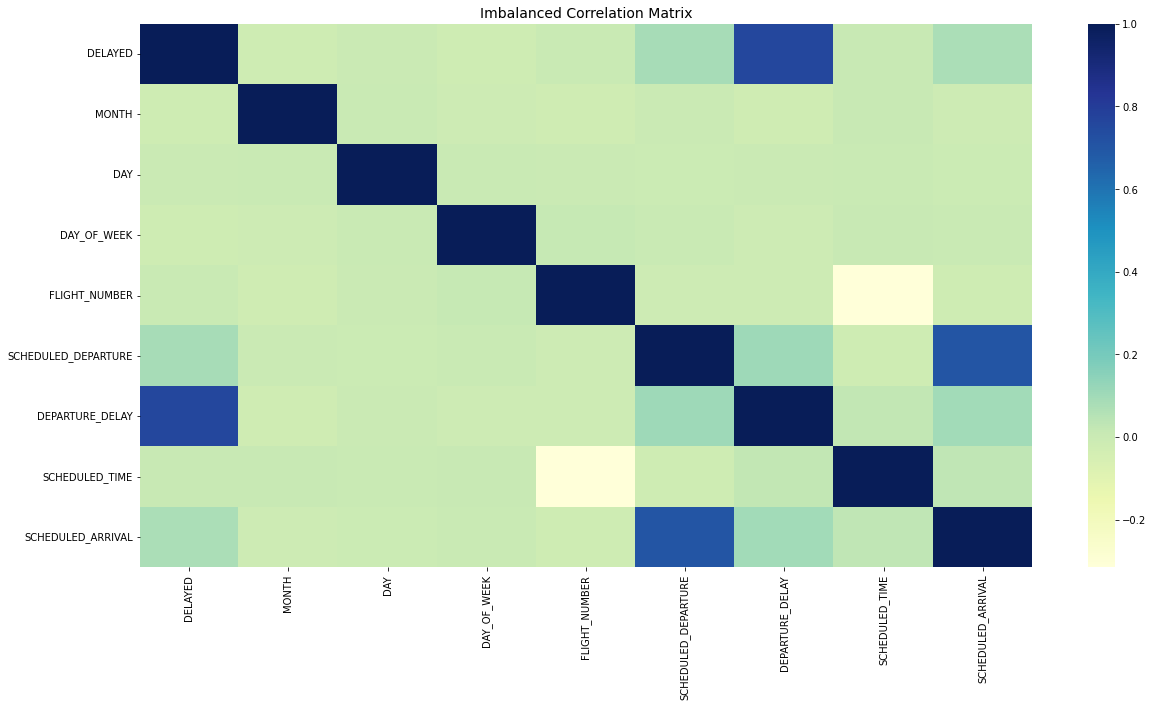

In [396]:
fig, ax = plt.subplots(figsize=(20,10))         
# Imbalanced DataFrame Correlation
corr = data.corr()
sns.heatmap(corr, cmap='YlGnBu', annot_kws={'size':30}, ax=ax)
ax.set_title("Imbalanced Correlation Matrix", fontsize=14)
plt.show()

**Tu wizualizacja wszystkich danych**

In [ ]:
sns.pairplot(data, hue="DELAYED", corner=True)

Dodajemy z powrotem usunięte wcześniej kolumny

In [380]:
data = pd.concat([data, alpha], axis=1)
print("Wartości NaN: {}".format(data.isnull().sum().sum()))
data = data.dropna(axis='rows', how='all', thresh=int(data.shape[1]))
print("Wartości NaN: {}".format(data.isnull().sum().sum()))

Wartości NaN: 4239
Wartości NaN: 0


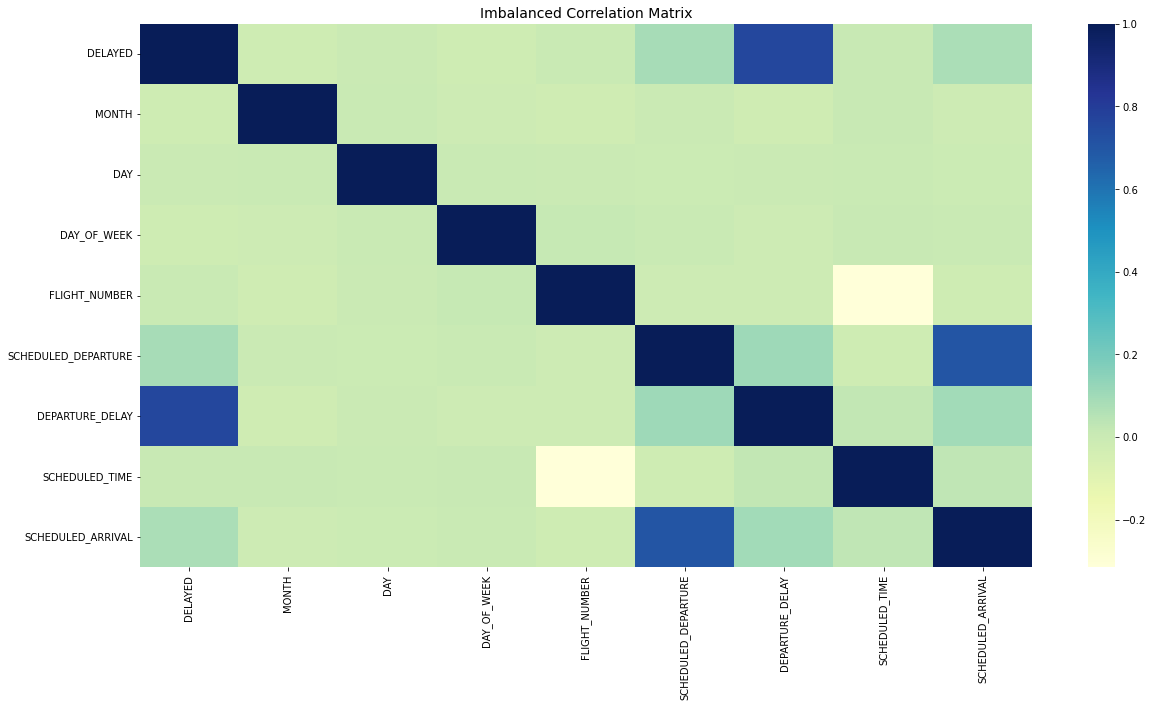

In [398]:
fig, ax = plt.subplots(figsize=(20,10))         
# Imbalanced DataFrame Correlation
corr = data.corr()
sns.heatmap(corr, cmap='YlGnBu', annot_kws={'size':30}, ax=ax)
ax.set_title("Imbalanced Correlation Matrix", fontsize=14)
plt.show()

In [399]:
data_part = data
data.describe()

,DELAYED,MONTH,DAY,DAY_OF_WEEK,FLIGHT_NUMBER,SCHEDULED_DEPARTURE,DEPARTURE_DELAY,SCHEDULED_TIME,SCHEDULED_ARRIVAL
count,285810.000000,285810.000000,285810.000000,285810.000000,285810.000000,285810.000000,285810.000000,285810.000000,285810.000000
mean,0.056499,6.541643,15.715286,3.926007,2163.650467,1328.993072,9.393797,141.831489,1493.077877
std,0.230883,3.397598,8.771325,1.985410,1755.848581,482.782944,37.268645,75.310708,507.074612
min,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-44.000000,18.000000,1.000000
25%,0.000000,4.000000,8.000000,2.000000,727.000000,919.000000,-5.000000,85.000000,1110.000000
50%,0.000000,7.000000,16.000000,4.000000,1681.000000,1325.000000,-2.000000,123.000000,1520.000000
75%,0.000000,9.000000,23.000000,6.000000,3207.000000,1730.000000,7.000000,174.000000,1916.000000
max,1.000000,12.000000,31.000000,7.000000,7438.000000,2359.000000,1576.000000,718.000000,2359.000000


Od razu podzielmy sobie dane na zbiór uczący i testowy, dzięki temu przy porównywaniu modeli będziemy mieć pewność, że każdy z nich jest testowany na dokładnie takich samych danych.

Tutaj podzielimy dane na dane wejściowe "X" i wyjściowe "y".

In [400]:
X = data.drop('DELAYED', axis=1)
y = data.loc[:, 'DELAYED']

Podzielmy je teraz na zbiory treningowe i testowe

In [401]:
# W tej komórce dzielimy cały zbiór na same zbiory testowy i treningowy, bez rodzielania na X i y, to zrobimy później, bo musimy najpierw zbalansować zbiór treningowy
train_data, test_data = train_test_split(data, test_size = 0.3, random_state=42)

Tu podzielimy zbiór testowy na X i y

In [402]:
X_test = test_data.drop('DELAYED', axis=1)
y_test = test_data.loc[:, 'DELAYED']

W tym momencie mamy dane po pre-pocessingu i możemy je dać do przetrawienia modelom.



---

#Regresja logistyczna


In [403]:
from sklearn.linear_model import LogisticRegression
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.over_sampling import SMOTE

Tworzymy instancję modelu, którą dopasujemy do danych treningowych

In [404]:
X_train = train_data.drop('DELAYED', axis=1)
y_train = train_data.loc[:, 'DELAYED']

Zanim wytrenujemy model, musimy wyrównać liczebności klas. W tym celu posłużymy się metodą oversamplingu o skrócie SMOTE.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


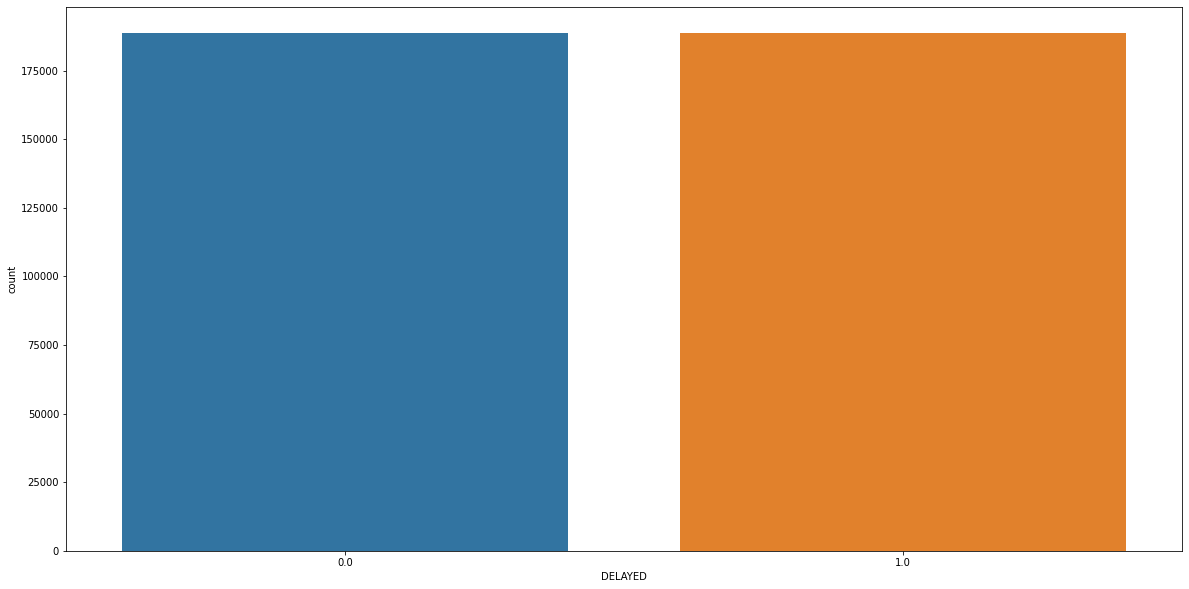

In [405]:
sm = SMOTE(sampling_strategy='minority', random_state=7)

# Fit the model to generate the data.
oversampled_trainX, oversampled_trainY = sm.fit_resample(train_data.drop('DELAYED', axis=1), train_data['DELAYED'])
oversampled_train = pd.concat([pd.DataFrame(oversampled_trainY), pd.DataFrame(oversampled_trainX)], axis=1)
train_data = oversampled_train

sns.countplot('DELAYED', data=train_data)

Dane normalizujemy na podstawie zbioru treningowego, ale dopasowujemy do scalera zarówno zbiór treningowy jak i testowy

In [406]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X = scaler.transform(X)

#### Trenujemy model

In [407]:
model_log = LogisticRegression(solver = 'lbfgs', max_iter=10000)

In [408]:
y_train = y_train.ravel()
model_log.fit(X_train, y_train)

LogisticRegression(max_iter=10000)

###Sprawdźmy na zbiorze testowym

In [409]:
y_pred = model_log.predict(X_test)  

In [410]:
print(metrics.classification_report(y_test, y_pred))
print(metrics.confusion_matrix(y_test, y_pred))

PPV = metrics.precision_score(y_test, y_pred)
REC = metrics.recall_score(y_test, y_pred)
ACC = metrics.accuracy_score(y_test, y_pred)
F1 = metrics.f1_score(y_test, y_pred)
MCC = metrics.matthews_corrcoef(y_test, y_pred)
print('PPV = {p:.3f} REC = {r:.3f} ACC = {a:.3f} F1 = {f:.3f} MCC =  {m:.3f}  '.format(a=ACC,f=F1,m=MCC,p=PPV,r=REC))

              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99     80943
         1.0       1.00      0.74      0.85      4800

    accuracy                           0.99     85743
   macro avg       0.99      0.87      0.92     85743
weighted avg       0.99      0.99      0.98     85743

[[80943     0]
 [ 1256  3544]]
PPV = 1.000 REC = 0.738 ACC = 0.985 F1 = 0.849 MCC =  0.853  


Fold no.0...
Fold no.1...
Fold no.2...
Fold no.3...
Fold no.4...
Fold no.5...
Fold no.6...
Fold no.7...
Fold no.8...
Fold no.9...


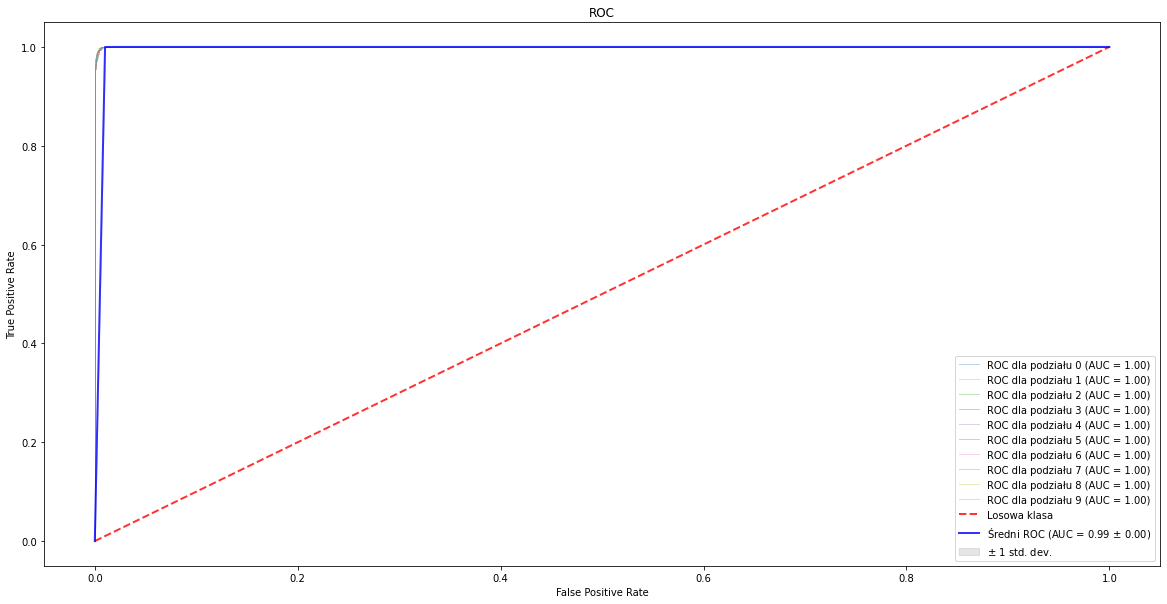

In [411]:
skf  = StratifiedKFold(n_splits=10)
model = model_log 
Y = y_train.ravel()
X = X_train
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
for train, test in skf.split(X, Y):
    print("Fold no.{}...".format(i))
    model.fit(X[train, :], Y[train]) # fitujemy regresję
    probas_ = model.predict_proba(X[test])  # obliczamy prawdopodobieństwa przynależności przykładów testowych 
                                            # do klas wg. wyuczonego klasyfikatora 
                                            # (zwraca on w danym wierszu prawdopodobieństaw dla każdej z możliwych klas)
   
    # Obliczamy punkty krzywej ROC 
    fpr, tpr, thresholds = metrics.roc_curve(Y[test], probas_[:, 1]) # względem prawdopodobieństwa klasy 1 
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    # i powierzchnię pod krzywą
    roc_auc = metrics.auc(fpr, tpr)
    aucs.append(roc_auc)
    # rysujemy krzywą 
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC dla podziału %d (AUC = %0.2f)' % (i, roc_auc))
    i += 1
    
    
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Losowa klasa', alpha=.8)
         
         
# poniżej podsumowanie: obliczanie średnich i standardowych odchyleń, cieniowanie przedziału ufności 
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = metrics.auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Średni ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

---
##Naive Bayes

Użyjemy tu klasyfikatora ComplementNB, ponieważ jest on zaprojektowany do pracy z nierównymi klasami, jak w naszym przypadku

In [291]:
from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, StandardScaler
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split, StratifiedShuffleSplit, GridSearchCV
from sklearn import metrics
from sklearn.utils import sample_weight
from sklearn.metrics import make_scorer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

In [321]:
all_together = y_train
unique_classes = np.unique(all_together)

c_w = class_weight.compute_class_weight(class_weight='balanced', classes=unique_classes, y=all_together)

c_weight = y_train.copy()
c_weight[c_weight == 1] = c_w[1]
c_weight[c_weight == 0] = c_w[0]

c_weight

array([0.52983845, 0.52983845, 0.52983845, ..., 0.52983845, 0.52983845,
       0.52983845])

In [328]:
model_NB = ComplementNB()

scoring = {"AUC": "roc_auc", "Precision": 'precision', "Accuracy": 'recall', "MCC": make_scorer(metrics.matthews_corrcoef), "F1": 'f1'}
grid_values = {'alpha': np.linspace(0, 10, 10),
  'fit_prior': [True, False],}
model_NB = GridSearchCV(model_NB, param_grid=grid_values, n_jobs=-1,
    return_train_score=True, refit='AUC', scoring=scoring)

model_NB.fit(X_train, y_train, sample_weight=c_weight)

model_NB = ComplementNB(alpha=model_NB.best_params_['alpha'], fit_prior=model_NB.best_params_['fit_prior'])

model_NB.fit(X_train, y_train, sample_weight=c_weight)

ComplementNB(alpha=10.0)

In [325]:
y_pred = model_NB.predict(X_test)
accur = accuracy_score(y_test, y_pred) # dokładność
print("Dokładność: %0.3f" % accur)
print("Classification report:") # wypisz raport klasyfikacji 
print(classification_report(y_test, y_pred))

print("Macierz błędów") # wypisz macierz (confusion matrix)
print(confusion_matrix(y_test, y_pred))

Dokładność: 0.553
Classification report:
              precision    recall  f1-score   support

         0.0       0.96      0.55      0.70     80862
         1.0       0.07      0.60      0.13      4881

    accuracy                           0.55     85743
   macro avg       0.52      0.57      0.42     85743
weighted avg       0.91      0.55      0.67     85743

Macierz błędów
[[44510 36352]
 [ 1960  2921]]


Fold no.0...
Fold no.1...
Fold no.2...
Fold no.3...
Fold no.4...
Fold no.5...
Fold no.6...
Fold no.7...
Fold no.8...
Fold no.9...


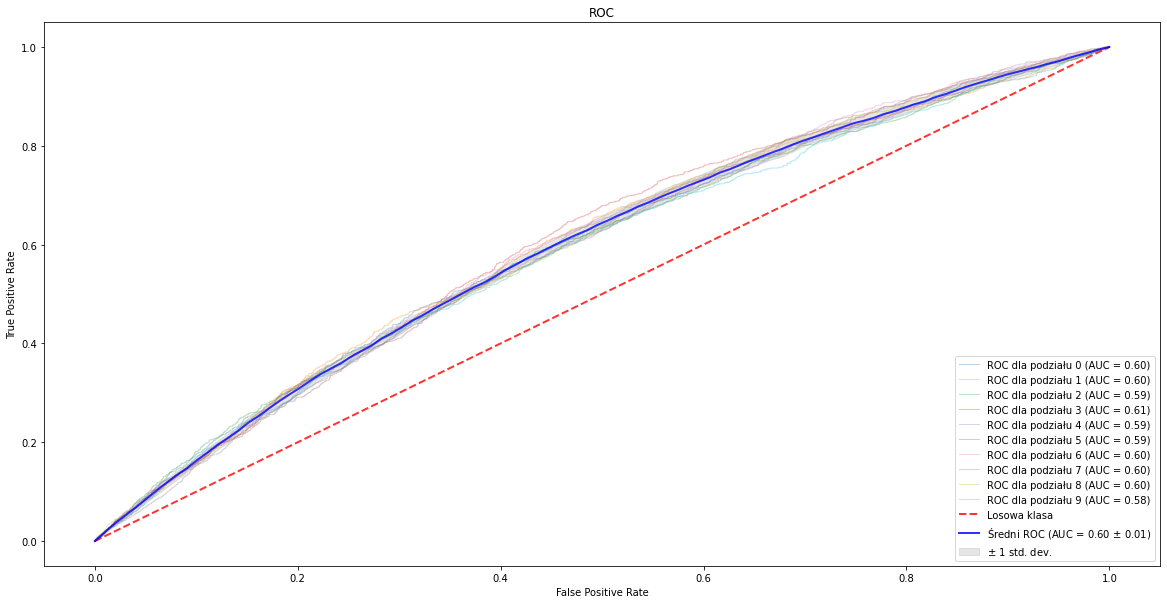

In [326]:
skf  = StratifiedKFold(n_splits=10)
model = model_NB 
Y = y_train.ravel()
X = X_train
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
for train, test in skf.split(X, Y):
    print("Fold no.{}...".format(i))
    model.fit(X[train, :], Y[train]) # fitujemy regresję
    probas_ = model.predict_proba(X[test])  # obliczamy prawdopodobieństwa przynależności przykładów testowych 
                                            # do klas wg. wyuczonego klasyfikatora 
                                            # (zwraca on w danym wierszu prawdopodobieństaw dla każdej z możliwych klas)
   
    # Obliczamy punkty krzywej ROC 
    fpr, tpr, thresholds = metrics.roc_curve(Y[test], probas_[:, 1]) # względem prawdopodobieństwa klasy 1 
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    # i powierzchnię pod krzywą
    roc_auc = metrics.auc(fpr, tpr)
    aucs.append(roc_auc)
    # rysujemy krzywą 
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC dla podziału %d (AUC = %0.2f)' % (i, roc_auc))
    i += 1
    
    
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Losowa klasa', alpha=.8)
         
         
# poniżej podsumowanie: obliczanie średnich i standardowych odchyleń, cieniowanie przedziału ufności 
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = metrics.auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Średni ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

---
## SVM

In [339]:
model_SVM = LinearSVC(dual=False, max_iter=10000)

grid_values = {'penalty': ['l2'], 'C': np.logspace(-10, 10,num=200)}
model_SVM = GridSearchCV(model_SVM, param_grid=grid_values, n_jobs=-1,
    return_train_score=True, refit='AUC', scoring=scoring)

model_SVM.fit(X_train, y_train, sample_weight=c_weight)

GridSearchCV(estimator=LinearSVC(dual=False, max_iter=10000), n_jobs=-1,
             param_grid={'C': array([1.00000000e-10, 1.26038293e-10, 1.58856513e-10, 2.00220037e-10,
       2.52353917e-10, 3.18062569e-10, 4.00880633e-10, 5.05263107e-10,
       6.36824994e-10, 8.02643352e-10, 1.01163798e-09, 1.27505124e-09,
       1.60705282e-09, 2.02550194e-09, 2.55290807e-09, 3.21764175e-09,
       4.05546074e-09, 5....
       3.10786619e+08, 3.91710149e+08, 4.93704785e+08, 6.22257084e+08,
       7.84282206e+08, 9.88495905e+08, 1.24588336e+09, 1.57029012e+09,
       1.97916687e+09, 2.49450814e+09, 3.14403547e+09, 3.96268864e+09,
       4.99450512e+09, 6.29498899e+09, 7.93409667e+09, 1.00000000e+10]),
                         'penalty': ['l2']},
             refit='AUC', return_train_score=True,
             scoring={'AUC': 'roc_auc',
                      'Accuracy': make_scorer(accuracy_score)})

In [340]:
# Walidacja 

from sklearn import metrics

y_pred = model_SVM.predict(X_test)
accur = accuracy_score(y_test, y_pred) # dokładność
print("Dokładność: %0.3f" % accur)
print("Classification report:") # wypisz raport klasyfikacji 
print(classification_report(y_test, y_pred))

print("Macierz błędów") # wypisz macierz (confusion matrix)
print(confusion_matrix(y_test, y_pred))

MCC = metrics.matthews_corrcoef(y_test, y_pred)
BACC = metrics.balanced_accuracy_score(y_test, y_pred)
print('MCC =  {m:.3f}, Balanced ACC = {b:.3f}  '.format(m=MCC, b=BACC))

Dokładność: 0.566
Classification report:
              precision    recall  f1-score   support

         0.0       0.96      0.56      0.71     80862
         1.0       0.08      0.62      0.14      4881

    accuracy                           0.57     85743
   macro avg       0.52      0.59      0.42     85743
weighted avg       0.91      0.57      0.68     85743

Macierz błędów
[[45498 35364]
 [ 1878  3003]]
MCC =  0.083, Balanced ACC = 0.589  


## Decision Trees

In [357]:
from sklearn import tree

# Deklarujemy klasyfikator
model_tree = tree.DecisionTreeClassifier(class_weight={0: 1, 1:100}, criterion='entropy', min_samples_split=10, max_leaf_nodes=100, max_depth=20)
# Fitujemy do danych treningowych
model_tree = model_tree.fit(X_train, y_train)

Wielkie drzewo, długo się liczy

In [65]:
# from IPython.display import Image 

# from six import StringIO
# import pydot 

# dot_data = StringIO()  
# tree.export_graphviz(model_tree, out_file=dot_data,  
                         # class_names=['Neutral', 'Positive', 'Negative'],  
                         # filled=True, rounded=True,  
                         # special_characters=True) 
# graph = pydot.graph_from_dot_data(dot_data.getvalue())  
# Image(graph[0].create_png())

In [359]:
y_pred = model_tree.predict(X_test)  

accur = accuracy_score(y_test, y_pred) # dokładność
print("Dokładność: %0.3f" % accur)
print("Classification report:") # wypisz raport klasyfikacji 
print(classification_report(y_test, y_pred))

print("Macierz błędów") # wypisz macierz (confusion matrix)
print(confusion_matrix(y_test, y_pred))

MCC = metrics.matthews_corrcoef(y_test, y_pred)
BACC = metrics.balanced_accuracy_score(y_test, y_pred)
print('MCC =  {m:.3f}, Balanced ACC = {b:.3f}  '.format(m=MCC, b=BACC))

Dokładność: 0.092
Classification report:
              precision    recall  f1-score   support

         0.0       0.98      0.04      0.07     80862
         1.0       0.06      0.99      0.11      4881

    accuracy                           0.09     85743
   macro avg       0.52      0.51      0.09     85743
weighted avg       0.93      0.09      0.07     85743

Macierz błędów
[[ 3045 77817]
 [   59  4822]]
MCC =  0.032, Balanced ACC = 0.513  


In [369]:
model_tree = tree.DecisionTreeClassifier(class_weight={0: 1, 1:100}, criterion='entropy')

# param_dict = {
#     "criterion":['gini', 'entropy'],
#     "max_depth": range(20,30),
#     "min_samples_split":range(10,20),
#     "min_samples_leaf":range(1,5)
# }

scoring = {"Precision": 'precision', "Accuracy": 'recall'}

model_tree = GridSearchCV(model_tree,
                          param_grid=param_dict,
                          cv=5,
                          verbose=1,
                          n_jobs=-1,
                          scoring=scoring,
                          refit='Precision'
                          )

model_tree.fit(X_train, y_train, sample_weight=c_weight)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


GridSearchCV(cv=3,
             estimator=DecisionTreeClassifier(class_weight={0: 1, 1: 100},
                                              criterion='entropy'),
             n_jobs=-1, param_grid={}, refit='Precision',
             scoring={'Accuracy': 'recall', 'Precision': 'precision'},
             verbose=1)

In [370]:
y_pred = model_tree.predict(X_test)  

accur = accuracy_score(y_test, y_pred) # dokładność
print("Dokładność: %0.3f" % accur)
print("Classification report:") # wypisz raport klasyfikacji 
print(classification_report(y_test, y_pred))

print("Macierz błędów") # wypisz macierz (confusion matrix)
print(confusion_matrix(y_test, y_pred))

MCC = metrics.matthews_corrcoef(y_test, y_pred)
BACC = metrics.balanced_accuracy_score(y_test, y_pred)
print('MCC =  {m:.3f}, Balanced ACC = {b:.3f}  '.format(m=MCC, b=BACC))

Dokładność: 0.903
Classification report:
              precision    recall  f1-score   support

         0.0       0.95      0.95      0.95     80862
         1.0       0.10      0.09      0.09      4881

    accuracy                           0.90     85743
   macro avg       0.52      0.52      0.52     85743
weighted avg       0.90      0.90      0.90     85743

Macierz błędów
[[76990  3872]
 [ 4459   422]]
MCC =  0.041, Balanced ACC = 0.519  


Fold no.0...
Fold no.1...
Fold no.2...
Fold no.3...
Fold no.4...
Fold no.5...
Fold no.6...
Fold no.7...
Fold no.8...
Fold no.9...


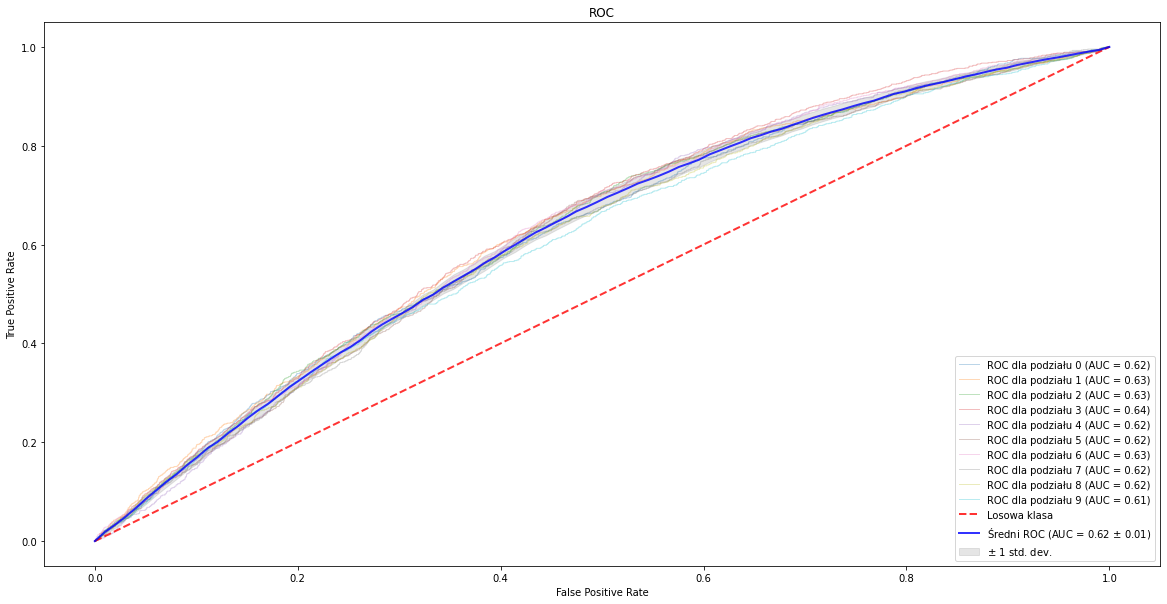

In [371]:
skf  = StratifiedKFold(n_splits=10)
model = model_log 
Y = y_train.ravel()
X = X_train
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
for train, test in skf.split(X, Y):
    print("Fold no.{}...".format(i))
    model.fit(X[train, :], Y[train]) # fitujemy regresję
    probas_ = model.predict_proba(X[test])  # obliczamy prawdopodobieństwa przynależności przykładów testowych 
                                            # do klas wg. wyuczonego klasyfikatora 
                                            # (zwraca on w danym wierszu prawdopodobieństaw dla każdej z możliwych klas)
   
    # Obliczamy punkty krzywej ROC 
    fpr, tpr, thresholds = metrics.roc_curve(Y[test], probas_[:, 1]) # względem prawdopodobieństwa klasy 1 
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    # i powierzchnię pod krzywą
    roc_auc = metrics.auc(fpr, tpr)
    aucs.append(roc_auc)
    # rysujemy krzywą 
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC dla podziału %d (AUC = %0.2f)' % (i, roc_auc))
    i += 1
    
    
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Losowa klasa', alpha=.8)
         
         
# poniżej podsumowanie: obliczanie średnich i standardowych odchyleń, cieniowanie przedziału ufności 
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = metrics.auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Średni ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

## Wnioski

Nie udało się stworzyć klasyfikatora, który w zadowalającym stopniu by odpowiadał na zadawane pytania/cele, głównie z racji ogromnej dysproporcji w danych obu klas.

Wyniki precyzji wychodzą relatywnie wysokie, ale to wynika tylko i wyłącznie z dysproporcji liczby przykładów klas, nie przekłada się to na rzeczywisty performance modeli.